Taken from https://mmla.gse.harvard.edu/tools/js-aruco-marker-detector/

1. Obtain borders of the marker (adaptative thresholding)
2. Find countours of the marker 
3. Remove borders with a small number of points
4. Polygonal approximation of contour and keep the concave contours with exactly 4 corners
5. Sort corners in an anti-clockwise direction
6. Remove too close rectangles. 
  This is required because the adaptive threshold normally detects the internal an external part of the marker's border
  At this stage, we keep the most external border.
7. Marker Identification
  7.1. Remove the projection perspective so as to obtain a frontal view of the rectangle area using a homography
  7.2. Threshold the area using Otsu
  7.3. Identification of the internal code
  7.4. For the valid markers, refine corners using subpixel interpolation

In [286]:
import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np

In [287]:
def show_image(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plt.axis("off")
    plt.imshow(image)
    plt.show()

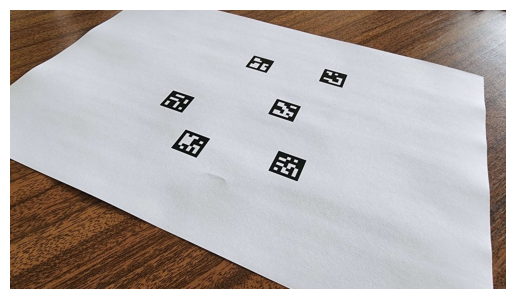

In [288]:
image = cv.imread("../data/images/markers.jpg")

show_image(image)

## Thresholding

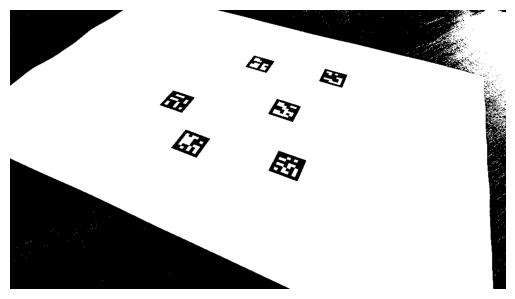

In [289]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
_, thresholded = cv.threshold(gray, 127, 255, cv.THRESH_BINARY) # Use Adaptative Thresholding

show_image(thresholded)

## Contours

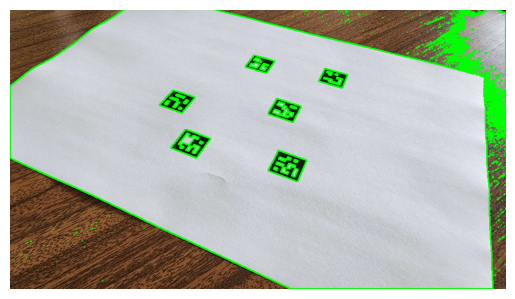

In [290]:
contours, hierarchy = cv.findContours(thresholded, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()

cv.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

show_image(contour_image)

## Remove borders

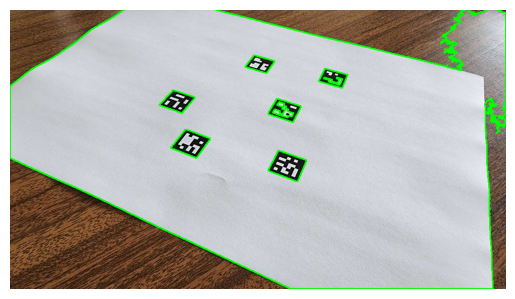

In [291]:
filtered_contours = [c for c in contours if len(c) > 70]
contour_image = image.copy()

cv.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)

show_image(contour_image)

## Polygonal approximation 

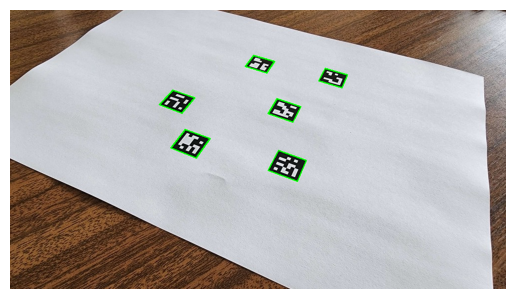

In [292]:
poly_contours = [cv.approxPolyDP(c, 3, True) for c in filtered_contours]
poly_contours = [c for c in poly_contours if len(c) == 4]
contour_image = image.copy()

cv.drawContours(contour_image, poly_contours, -1, (0, 255, 0), 2)

show_image(contour_image)

In [293]:
def angle_with_reference(point, reference_point):
    x, y = point[0] - reference_point[0], point[1] - reference_point[1]
    
    return math.atan2(y, x)

def sort_corners_anticlockwise(corners):
    # Find the centroid as a reference point
    reference_point = (
        sum(x for x, _ in corners) / len(corners),
        sum(y for _, y in corners) / len(corners)
    )
    
    # Sort corners based on angles with respect to the reference point
    sorted_corners = sorted(
        corners,
        key=lambda point: angle_with_reference(point, reference_point),
        reverse=True  # Sorting in anti-clockwise order
    )
    
    return sorted_corners

# Get corners of contours
corners = [c.reshape(-1, 2) for c in poly_contours]
sorted_corners = np.array(list(map(sort_corners_anticlockwise, corners)))

## Remove too close rectangles

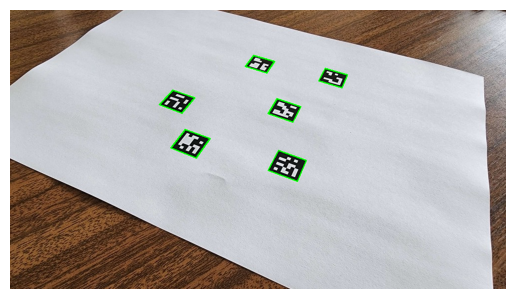

In [294]:
def is_too_close(rect1, rect2):
    return np.linalg.norm(rect1 - rect2) < 100

def remove_close_rectangles(rectangles):
    filtered_rectangles = []
    
    for rectangle in rectangles:
        if not any(is_too_close(rectangle, r) for r in filtered_rectangles):
            filtered_rectangles.append(rectangle)
    
    return filtered_rectangles

filtered_rectangles = remove_close_rectangles(sorted_corners)

contour_image = image.copy()

cv.drawContours(contour_image, filtered_rectangles, -1, (0, 255, 0), 2)

show_image(contour_image)

## Marker identification

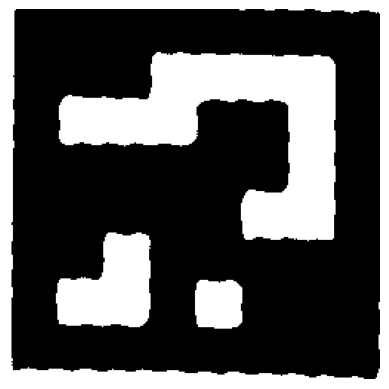

In [295]:
# Remove the projection perspective so as to obtain a frontal view of the rectangle area using a homography
def get_frontal_view(image, corners):
    # Define the dimensions of the target image
    width, height = 250, 250
    
    # Define the target points
    target_points = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ], dtype=np.float32)
    
    # Get the transformation matrix
    transformation_matrix, _ = cv.findHomography(corners, target_points)
    
    # Apply the transformation matrix to the source image
    warped = cv.warpPerspective(image, transformation_matrix, (width, height))

    _, marker = cv.threshold(warped, 127, 255, cv.THRESH_BINARY)

    return marker

markers = [get_frontal_view(gray, c) for c in filtered_rectangles]

show_image(markers[4])